<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/New_Focal_Loss_ResNet50_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU**

In [0]:
!nvidia-smi

Wed May 20 15:58:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# **Import Libraries**

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# **Clone Data**

In [0]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

fatal: destination path 'ham10000-with-one-image-folder' already exists and is not an empty directory.


# **Constant Variables**

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# **Prepare Data**

In [0]:
data=pd.read_csv('/content/ham10000-with-one-image-folder/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [0]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_full_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


### **Split Data**

In [0]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [0]:
train = pd.concat([X_train,y_train],axis=1)
val = pd.concat([X_val,y_val],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train['dx'])
name_as_indexes_train = encoder.transform(train['dx']) 
train['label'] = name_as_indexes_train

In [0]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_val = encoder.transform(val['dx']) 
val['label'] = name_as_indexes_val

In [0]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

### **Data Augmentation**

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
test_generator=ImageDataGenerator(rescale = 1./255)
test_generator=ImageDataGenerator(rescale = 1./255)

In [0]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                                shuffle=True,batch_size=32,class_mode="categorical",target_size=(IMG_WIDTH,IMG_HEIGHT))

val_data= test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=True,batch_size=32,class_mode='categorical',target_size=(IMG_WIDTH,IMG_HEIGHT))

test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 6309 validated image filenames belonging to 7 classes.
Found 2704 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames.


# **Focal Loss**

https://github.com/mkocabas/focal-loss-keras






$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

# **Build Model**

### **Use ResNet50 + fine tuning**

In [0]:
def build_model():
  base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  
  model.compile(optimizer=Adam(LR), loss=[focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])
  return model

In [0]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### **Architecture**

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### **Callbacks**

In [0]:
model_path = '/content/Focal-Loss_ResNet50_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_plateau = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.00001)

In [0]:
cb_list = [checkpoint, early_stop, reduce_plateau]

### **Training**

In [0]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=EPOCHS,
                            callbacks=cb_list)

Epoch 1/100
 84/197 [===========>..................] - ETA: 36s - loss: 1.1623 - acc: 0.0078
Epoch 00001: val_loss improved from -inf to 1.16228, saving model to /content/Focal-Loss_ResNet50_model.h5
197/197 [==============================] - 183s 927ms/step - loss: 0.1038 - acc: 0.2061 - val_loss: 1.1623 - val_acc: 0.0078
Epoch 2/100
 84/197 [===========>..................] - ETA: 36s - loss: 2.0808 - acc: 0.0078
Epoch 00002: val_loss improved from 1.16228 to 2.08076, saving model to /content/Focal-Loss_ResNet50_model.h5
197/197 [==============================] - 152s 770ms/step - loss: 0.0792 - acc: 0.3224 - val_loss: 2.0808 - val_acc: 0.0078
Epoch 3/100
 84/197 [===========>..................] - ETA: 36s - loss: 1.2576 - acc: 0.0089
Epoch 00003: val_loss did not improve from 2.08076
197/197 [==============================] - 151s 764ms/step - loss: 0.0709 - acc: 0.3921 - val_loss: 1.2576 - val_acc: 0.0089
Epoch 4/100
 84/197 [===========>..................] - ETA: 36s - loss: 0.8316

In [0]:
model.save_weights('/content/Focal-Loss_ResNet50_weights.h5')

# **Accuracy and Loss Graph**

### **Accuracy**

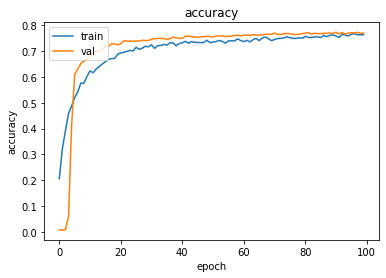

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### **Loss**

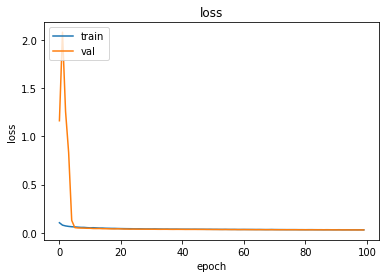

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [0]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

1002/1002 [==============================] - 15s 15ms/step


### **Classification Report**

In [0]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(name_as_indexes_test, y_pred))
print('Classification Report')
classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(name_as_indexes_test, y_pred, target_names=classes_names))

Confusion Matrix
[[  8   4  15   0   8   6   0]
 [  1  25   7   0   6   8   0]
 [  3   6  68   0  17  31   0]
 [  0   0   4   1   2   7   1]
 [  0   3  12   0  55  39   1]
 [  0   2  16   0  22 607   2]
 [  0   0   3   0   0   1  11]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.67      0.20      0.30        41
         bcc       0.62      0.53      0.57        47
         bkl       0.54      0.54      0.54       125
          df       1.00      0.07      0.12        15
         mel       0.50      0.50      0.50       110
          nv       0.87      0.94      0.90       649
        vasc       0.73      0.73      0.73        15

    accuracy                           0.77      1002
   macro avg       0.71      0.50      0.53      1002
weighted avg       0.77      0.77      0.76      1002



### **Confusion Matrix**

Confusion matrix, without normalization
[[  8   4  15   0   8   6   0]
 [  1  25   7   0   6   8   0]
 [  3   6  68   0  17  31   0]
 [  0   0   4   1   2   7   1]
 [  0   3  12   0  55  39   1]
 [  0   2  16   0  22 607   2]
 [  0   0   3   0   0   1  11]]


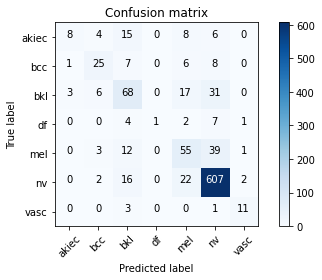

In [0]:
cm = (confusion_matrix(name_as_indexes_test, y_pred))

plot_confusion_matrix(cm, classes_names)

### **Sensitivity & Specificity**

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [0]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.6667
specificity: 0.9615


# **Grad-CAM**

In [0]:
last_conv2d = 'conv5_block3_3_conv'

### **AKIEC**

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.854
	bkl            	(2)	with probability 0.033
	nv             	(5)	with probability 0.029
	akiec          	(0)	with probability 0.022
	bcc            	(1)	with probability 0.022
Explanation for 'mel'


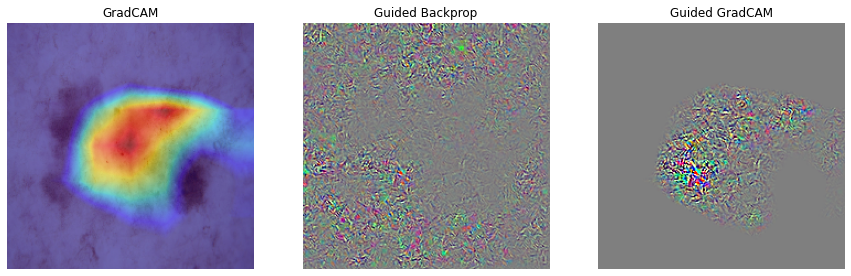

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

### **BCC**

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	mel            	(4)	with probability 0.408
	nv             	(5)	with probability 0.298
	bkl            	(2)	with probability 0.084
	vasc           	(6)	with probability 0.061
	akiec          	(0)	with probability 0.058
Explanation for 'mel'


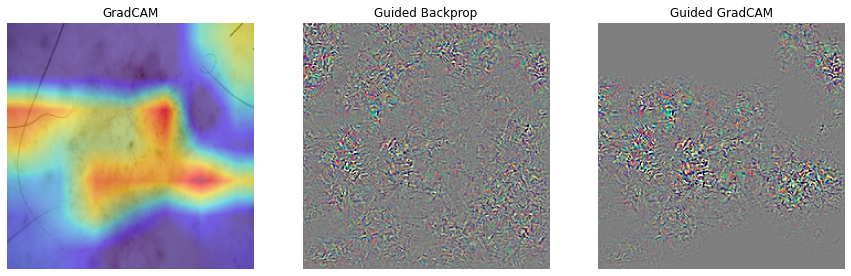

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

### **BKL**

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	nv             	(5)	with probability 0.478
	mel            	(4)	with probability 0.252
	bkl            	(2)	with probability 0.109
	vasc           	(6)	with probability 0.081
	bcc            	(1)	with probability 0.044
Explanation for 'nv'


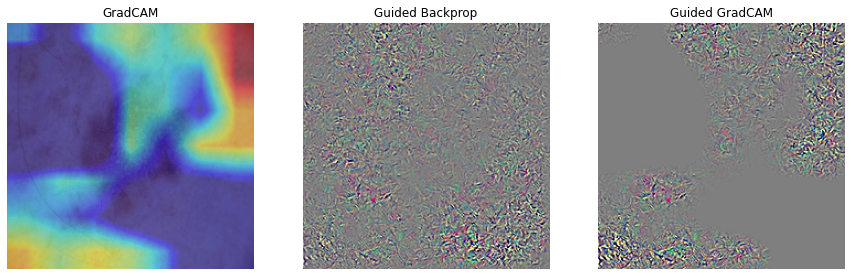

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### **DF**

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.568
	nv             	(5)	with probability 0.370
	vasc           	(6)	with probability 0.024
	bkl            	(2)	with probability 0.017
	df             	(3)	with probability 0.010
Explanation for 'mel'


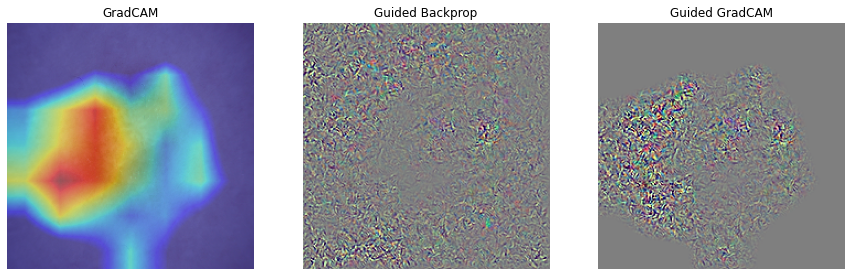

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### **MEL**

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	nv             	(5)	with probability 0.558
	mel            	(4)	with probability 0.266
	bkl            	(2)	with probability 0.069
	vasc           	(6)	with probability 0.064
	bcc            	(1)	with probability 0.016
Explanation for 'nv'


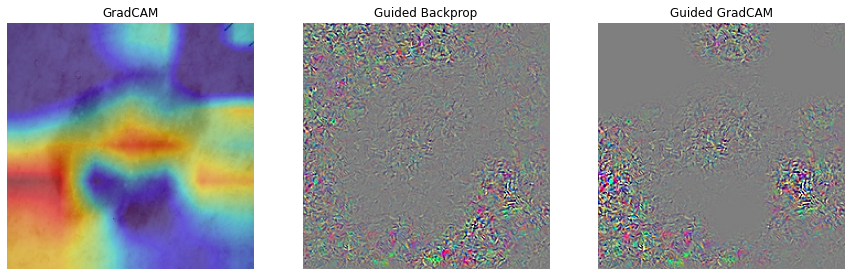

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### **NV**

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	nv             	(5)	with probability 0.382
	vasc           	(6)	with probability 0.317
	mel            	(4)	with probability 0.145
	bkl            	(2)	with probability 0.071
	df             	(3)	with probability 0.040
Explanation for 'nv'


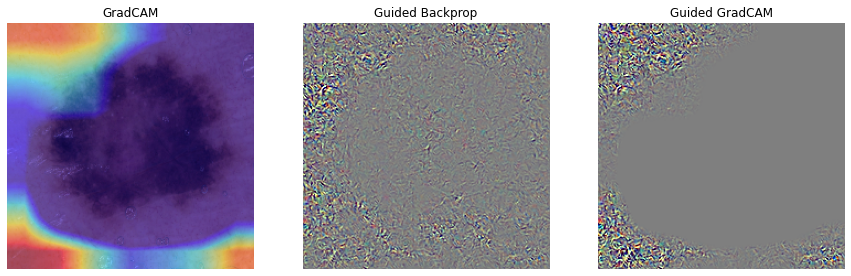

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### **VASC**

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	nv             	(5)	with probability 0.691
	vasc           	(6)	with probability 0.204
	bkl            	(2)	with probability 0.027
	bcc            	(1)	with probability 0.026
	mel            	(4)	with probability 0.023
Explanation for 'nv'


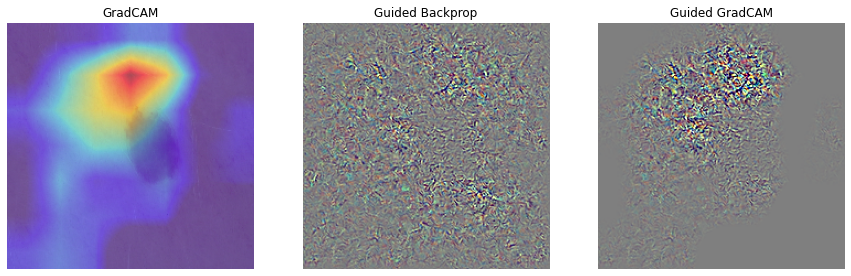

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# **Download Model**

In [0]:
from google.colab import files

In [0]:
files.download('/content/Focal-Loss_ResNet50_model.h5')
files.download('/content/Focal-Loss_ResNet50_weights.h5')

MessageError: ignored